In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

logger = logging.getLogger(__name__)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from dataclasses import replace

import torch
from torch import nn, optim

from src.models.nn import ActivationParams
from src.models.mlp import FCLayerParams, MLPParams, MLPEvaluator
from src.models.quant.enums import ActivationModule, QMode

from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.cardio_dataset import CardioDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset

INFO: Loading cached vertebral from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl
INFO: Loading cached cardio from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/cardio_cache.pkl
INFO: Loading cached breast_cancer from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/breast_cancer_cache.pkl


In [3]:
import torch
from src.models.quant.ternarize import Binarize, Ternarize

dummy_input = torch.tensor([[1.0, 2.0, -2.0], [90.0, 0.0, -110.9]])
Binarize(dummy_input), Ternarize(dummy_input)

(tensor([[   1.6667,    1.6667,   -1.6667],
         [ 100.4500, -100.4500, -100.4500]]),
 tensor([[   0.0000,    2.0000,   -2.0000],
         [ 100.4500,    0.0000, -100.4500]]))

# Histogram MLP

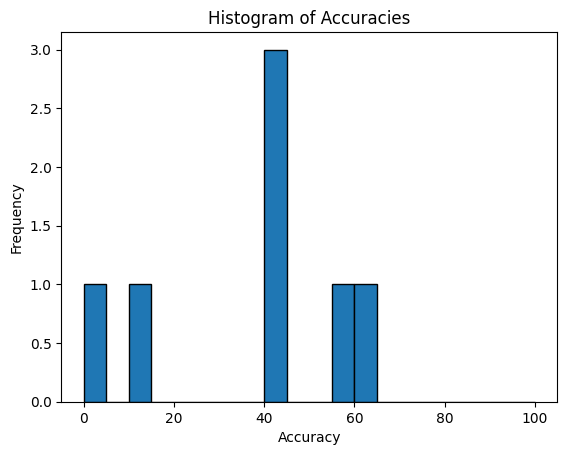

In [5]:
from matplotlib import pyplot as plt


def hist_accuracies(accuracies: list[float], bins=20) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=bins, range=(0, 100), edgecolor="black")
    ax.set_title("Histogram of Accuracies")
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("Frequency")
    return fig


fig = hist_accuracies([1, 14, 43, 63, 44, 44, 56])

In [5]:
DatasetClass = VertebralDataset

train_loader, test_loader = DatasetClass.get_dataloaders(batch_size=64)

p = MLPParams(
    layers=[
        FCLayerParams(DatasetClass.input_size, bitwidth=8),
        FCLayerParams(16, bitwidth=4),
        FCLayerParams(16, bitwidth=4),
        FCLayerParams(DatasetClass.output_size, bitwidth=32),
    ],
    learning_rate=0.01,
    activation=ActivationParams(
        activation=ActivationModule.BINARIZE_RESTE,
        binary_quantization_mode=QMode.DET,
    ),
    epochs=30,
    dropout_rate=0.0,
    quantization_mode=QMode.DET,
)

evaluator = MLPEvaluator(train_loader, test_loader)

In [6]:
from src.models.mlp import MLP


MLP(p).summarize_architecture()

[{'index': 0, 'type': 'Module_Quantize', 'details': 'Module_Quantize()'},
 {'index': 1,
  'type': 'Linear',
  'details': 'Linear(in_features=6, out_features=16, bias=True)'},
 {'index': 2,
  'type': 'BatchNorm1d',
  'details': 'BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)'},
 {'index': 3, 'type': 'Module_Quantize', 'details': 'Module_Quantize()'},
 {'index': 4,
  'type': 'Module_Binarize_ReSTE',
  'details': 'Module_Binarize_ReSTE()'},
 {'index': 5,
  'type': 'Linear',
  'details': 'Linear(in_features=16, out_features=16, bias=True)'},
 {'index': 6,
  'type': 'BatchNorm1d',
  'details': 'BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)'},
 {'index': 7, 'type': 'Module_Quantize', 'details': 'Module_Quantize()'},
 {'index': 8,
  'type': 'Module_Binarize_ReSTE',
  'details': 'Module_Binarize_ReSTE()'},
 {'index': 9,
  'type': 'Linear',
  'details': 'Linear(in_features=16, out_features=3, bias=True)'},
 {'index': 10,
  'type

In [7]:
from src.models.mlp import BMLP


BMLP(p).summarize_architecture()

[{'index': 0, 'type': 'Module_Quantize', 'details': 'Module_Quantize()'},
 {'index': 1,
  'type': 'BinarizeLinear',
  'details': 'BinarizeLinear(in_features=6, out_features=16, bias=True)'},
 {'index': 2,
  'type': 'BatchNorm1d',
  'details': 'BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)'},
 {'index': 3,
  'type': 'Module_Binarize_ReSTE',
  'details': 'Module_Binarize_ReSTE()'},
 {'index': 4,
  'type': 'BinarizeLinear',
  'details': 'BinarizeLinear(in_features=16, out_features=16, bias=True)'},
 {'index': 5,
  'type': 'BatchNorm1d',
  'details': 'BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)'},
 {'index': 6,
  'type': 'Module_Binarize_ReSTE',
  'details': 'Module_Binarize_ReSTE()'},
 {'index': 7,
  'type': 'BinarizeLinear',
  'details': 'BinarizeLinear(in_features=16, out_features=3, bias=True)'},
 {'index': 8,
  'type': 'BatchNorm1d',
  'details': 'BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_st

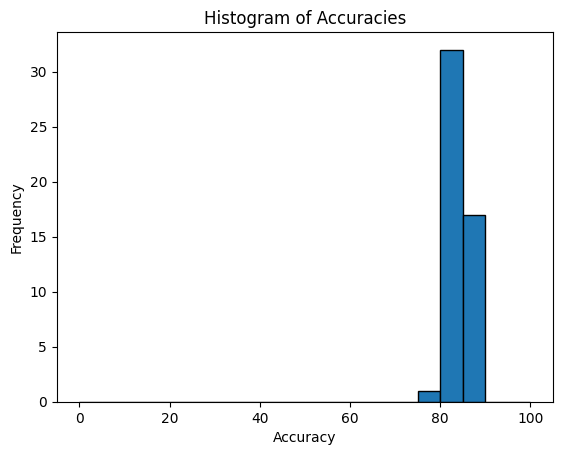

In [15]:
accuracies1 = []
for _ in range(50):
    best_acc = evaluator.train_model(p, BMLP)
    accuracies1.append(best_acc)

fig = hist_accuracies(accuracies1)
# accuracies1

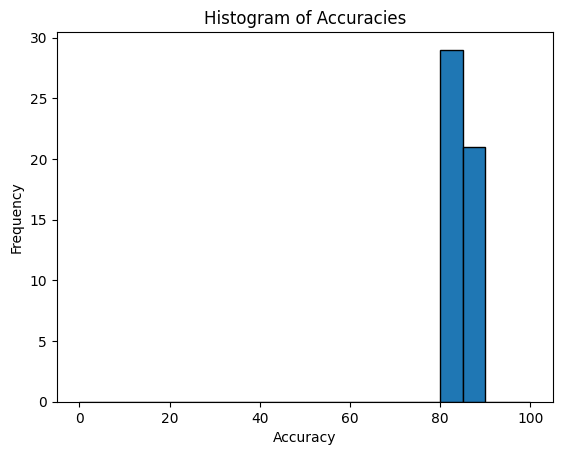

In [16]:
p_reste = replace(p)
p_reste.activation.activation = ActivationModule.BINARIZE_RESTE

accuracies2 = []
for _ in range(50):
    best_acc = evaluator.train_model(p_reste, BMLP)
    accuracies2.append(best_acc)

fig = hist_accuracies(accuracies2)
# accuracies2

In [23]:
from torch import nn, optim
from src.constants import DEVICE


# Create a dictionary to store features
features = {}

# Define a hook function
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook


model = BMLP(p).to(DEVICE)


for i, layer in enumerate(model.layers):
    # Register the hook to the forward method of the layer
    layer.register_forward_hook(get_features(f"{i}_{layer.__class__.__name__}"))



best_accuracy = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=p.learning_rate,
    weight_decay=p.weight_decay,
)

for epoch in range(1, p.epochs + 1):
    loss = evaluator.train_epoch(model, optimizer, criterion, epoch)
    accuracy = evaluator.test_model(model, criterion)
    evaluator.train_log.append({"epoch": epoch, "loss": loss, "accuracy": accuracy})

    best_accuracy = max(best_accuracy, accuracy)

    if evaluator.should_stop_early(loss):
        logger.debug(f"Early stopping triggered after {epoch + 1} epochs")
        break

best_accuracy

36.85446009389671

([43.89671361502347,
  40.375586854460096,
  36.3849765258216,
  45.539906103286384,
  40.610328638497656,
  43.42723004694836,
  32.159624413145536,
  38.732394366197184,
  38.967136150234744,
  37.55868544600939],
 [41.31455399061033,
  46.009389671361504,
  41.31455399061033,
  36.61971830985915,
  38.732394366197184,
  42.25352112676056,
  41.31455399061033,
  39.671361502347416,
  41.54929577464789,
  32.629107981220656])

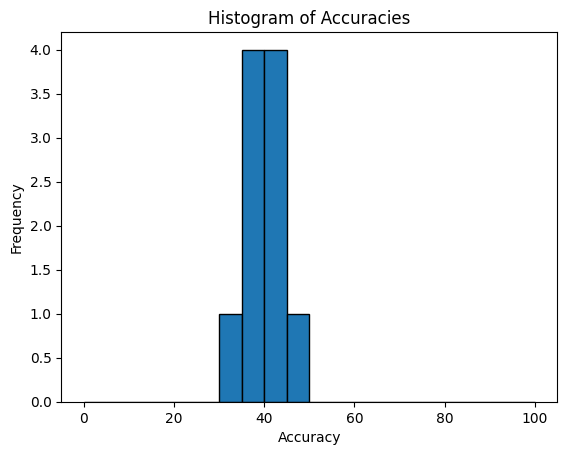

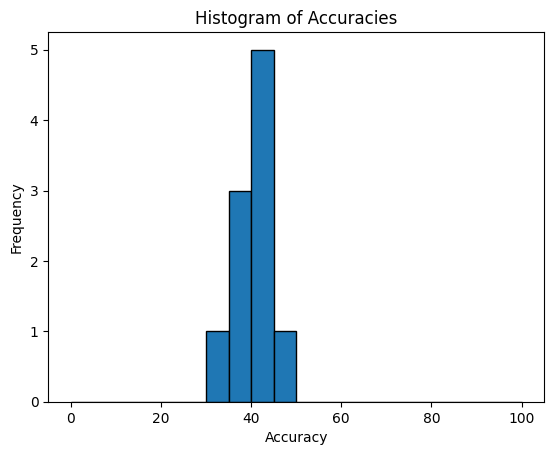

In [37]:
accuracies = []
for _ in range(10):
    best_acc = evaluator.train_model(p)
    accuracies.append(best_acc)

fig = hist_accuracies(accuracies)

p2 = replace(p)
p2.layers[-1].bitwidth = 16

accuracies2 = []
for _ in range(10):
    best_acc = evaluator.train_model(p2)
    accuracies2.append(best_acc)

fig = hist_accuracies(accuracies2)

accuracies, accuracies2

[42.25352112676056]

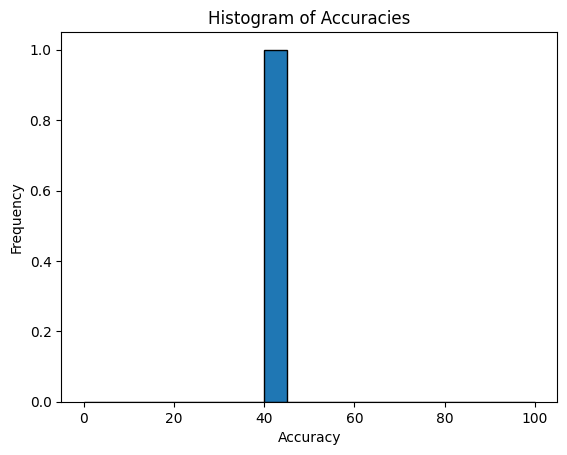

In [ ]:
accuracies1 = []
for _ in range(20):
    best_acc = evaluator.train_model(p)
    accuracies1.append(best_acc)

fig = hist_accuracies(accuracies1)
accuracies1

[44.13145539906103,
 43.42723004694836,
 43.66197183098591,
 37.32394366197183,
 40.375586854460096,
 38.262910798122064,
 40.375586854460096,
 42.72300469483568,
 37.79342723004695,
 44.60093896713615,
 43.66197183098591,
 37.79342723004695,
 40.610328638497656,
 42.25352112676056,
 42.72300469483568,
 47.183098591549296,
 42.72300469483568,
 46.948356807511736,
 42.48826291079812,
 37.32394366197183]

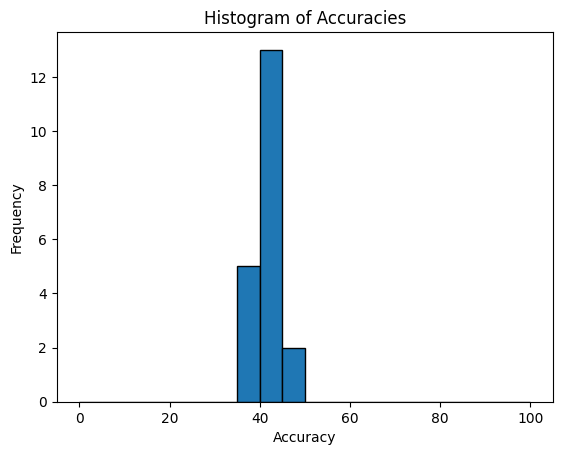

In [40]:
p2 = replace(p)
p2.activation.activation = ActivationModule.BINARIZE

accuracies2 = []
for _ in range(20):
    best_acc = evaluator.train_model(p2)
    accuracies2.append(best_acc)

fig = hist_accuracies(accuracies2)
accuracies2

In [17]:
from scipy import stats

set1, set2 = (accuracies1, accuracies2)

# Perform paired t-test (one-tailed: set1 > set2)
t_stat, p_value = stats.ttest_rel(set1, set2, alternative="greater")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")

# Interpret results
if p_value < 0.10:
    print("Set1 is significantly higher than Set2 (p < 0.10)")
else:
    print("No significant difference detected")

t-statistic: -1.107, p-value: 0.8632
No significant difference detected


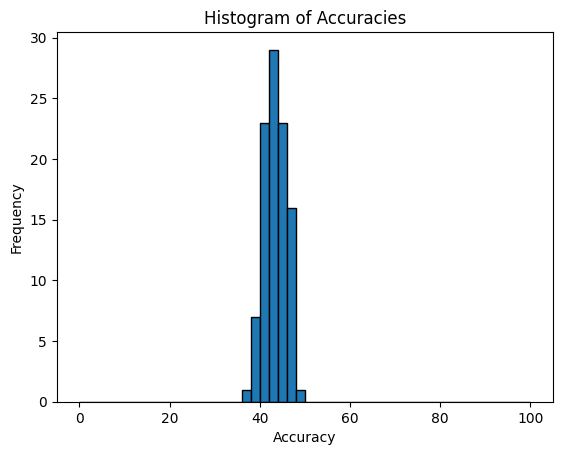

In [42]:
fig = hist_accuracies(accuracies, bins=50)

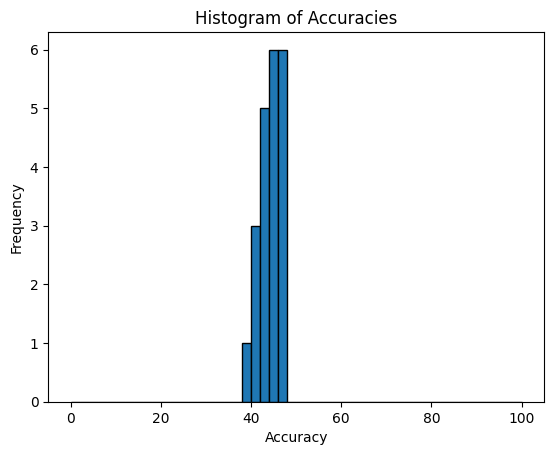

In [82]:
import random


offset = random.randint(0, 80)
fig = hist_accuracies(accuracies[offset:offset+20+1], bins=50)

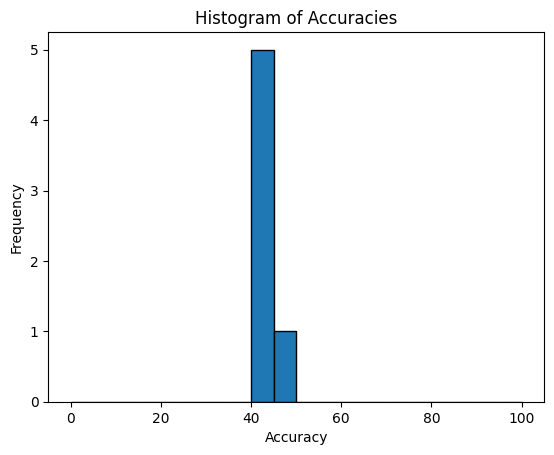

In [10]:
fig = hist_accuracies(accuracies[0:5+1])

[46.713615023474176,
 40.84507042253521,
 47.88732394366197,
 41.07981220657277,
 41.78403755868545,
 40.84507042253521,
 46.009389671361504,
 43.89671361502347,
 46.948356807511736,
 41.31455399061033,
 41.31455399061033,
 41.54929577464789,
 42.95774647887324,
 44.83568075117371,
 41.07981220657277,
 38.732394366197184,
 42.72300469483568,
 43.42723004694836,
 44.60093896713615,
 41.78403755868545]

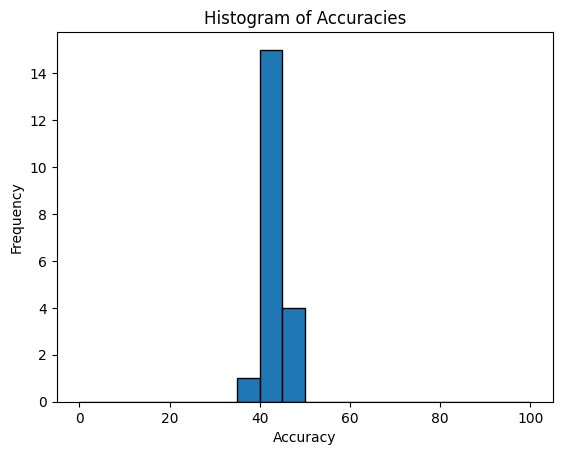

In [ ]:
from dataclasses import replace

p2 = replace(p)
p2.activation.activation = ActivationModule.BINARIZE_RESTE

accuracies = []
for _ in range(20):
    best_acc = evaluator.train_model(p2)
    accuracies.append(best_acc)

fig = hist_accuracies(accuracies)
accuracies

[39.671361502347416,
 47.417840375586856,
 39.436619718309856,
 47.88732394366197,
 43.66197183098591,
 41.78403755868545,
 46.009389671361504,
 39.201877934272304,
 41.78403755868545,
 41.78403755868545,
 39.436619718309856,
 40.375586854460096,
 42.48826291079812,
 48.35680751173709,
 43.42723004694836,
 46.244131455399064,
 44.13145539906103,
 42.25352112676056,
 49.76525821596244,
 44.13145539906103]

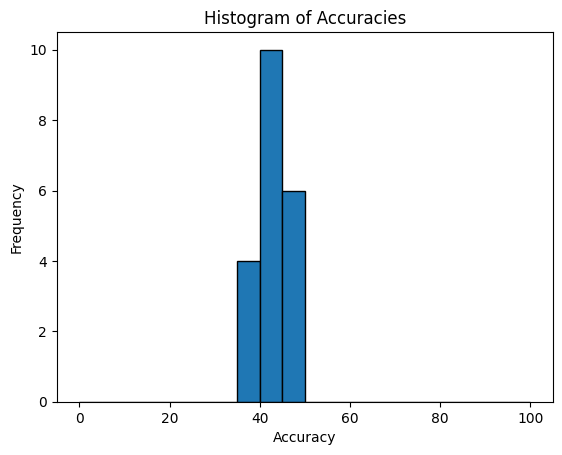

In [ ]:
p2.activation.reste_threshold = 1.5
p2.activation.reste_o = 3.0

accuracies = []
for _ in range(20):
    best_acc = evaluator.train_model(p2)
    accuracies.append(best_acc)

fig = hist_accuracies(accuracies)
accuracies

[45.070422535211264,
 43.66197183098591,
 48.12206572769953,
 45.539906103286384,
 44.60093896713615,
 45.305164319248824,
 43.66197183098591,
 41.54929577464789,
 40.84507042253521,
 43.66197183098591,
 42.72300469483568,
 44.83568075117371,
 42.48826291079812,
 43.89671361502347,
 43.1924882629108,
 42.48826291079812,
 41.07981220657277,
 42.72300469483568,
 40.140845070422536,
 40.84507042253521]

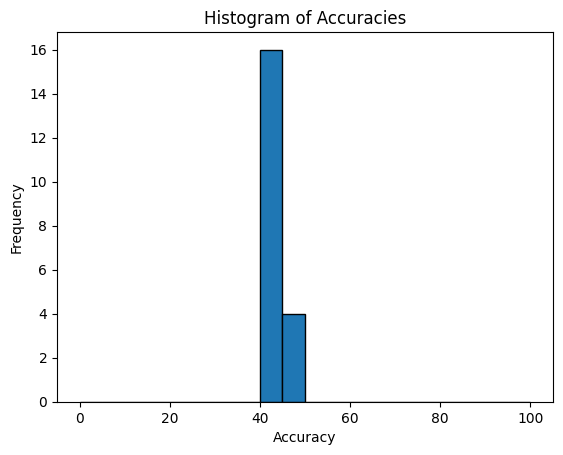

In [ ]:
p2.activation.reste_threshold = 3.0
p2.activation.reste_o = 3.0

accuracies = []
for _ in range(20):
    best_acc = evaluator.train_model(p2)
    accuracies.append(best_acc)

fig = hist_accuracies(accuracies)
accuracies

In [8]:
l1 = [46.713615023474176,
 40.84507042253521,
 47.88732394366197,
 41.07981220657277,
 41.78403755868545,
 40.84507042253521,
 46.009389671361504,
 43.89671361502347,
 46.948356807511736,
 41.31455399061033,
 41.31455399061033,
 41.54929577464789,
 42.95774647887324,
 44.83568075117371,
 41.07981220657277,
 38.732394366197184,
 42.72300469483568,
 43.42723004694836,
 44.60093896713615,
 41.78403755868545]
l2 = [39.671361502347416,
 47.417840375586856,
 39.436619718309856,
 47.88732394366197,
 43.66197183098591,
 41.78403755868545,
 46.009389671361504,
 39.201877934272304,
 41.78403755868545,
 41.78403755868545,
 39.436619718309856,
 40.375586854460096,
 42.48826291079812,
 48.35680751173709,
 43.42723004694836,
 46.244131455399064,
 44.13145539906103,
 42.25352112676056,
 49.76525821596244,
 44.13145539906103]
l3 = accuracies


In [ ]:
import numpy as np
nn.functional.conv2d()

(max(l1), np.mean(l1), np.std(l1)), (max(l2),np.mean(l2), np.std(l2)), (max(l3),np.mean(l3), np.std(l3))

((47.88732394366197,
  np.float64(43.01643192488263),
  np.float64(2.3972124756148347)),
 (49.76525821596244,
  np.float64(43.462441314553985),
  np.float64(3.157495149277752)),
 (48.12206572769953,
  np.float64(43.321596244131456),
  np.float64(1.900502595324753)))

# Histogram CNN

In [ ]:
from src.datasets.mnist_dataset import MiniMNISTDataset
from src.models.cnn import test_cnn, train_cnn_epoch
from src.models.tmp import BCNN, BCNN_ReSTE, TCNN
from src.models.resnet import ResNet

from src.constants import DEVICE


train_loader, test_loader = MiniMNISTDataset.get_dataloaders(batch_size=128)
model = ResNet(n=3, shortcuts=False).to(DEVICE)
patience = 5

min_loss = float("inf")
best_test_acc = 0
without_consecutive_improvements = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 5 + 1):

    loss = train_cnn_epoch(
        model, optimizer, criterion, train_loader, epoch, print_state=True
    )

    # Retain the best accuracy
    test_acc = test_cnn(model, criterion, test_loader, print_state=True)
    if test_acc > best_test_acc:
        best_test_acc = test_acc

    # Early stopping
    if loss < min_loss:
        min_loss = loss
        without_consecutive_improvements = 0
    else:
        without_consecutive_improvements += 1

    if without_consecutive_improvements >= patience:
        logger.info(f"Early stopping triggered after {epoch + 1} epochs")
        break

INFO: Train Epoch: 1 [0/4000] Loss: 2.4718
INFO: Train Epoch: 1 [640/4000] Loss: 2.2194
INFO: Train Epoch: 1 [1280/4000] Loss: 2.0175
INFO: Train Epoch: 1 [1920/4000] Loss: 1.8875
INFO: Train Epoch: 1 [2560/4000] Loss: 1.6252
INFO: Train Epoch: 1 [3200/4000] Loss: 1.4846
INFO: Train Epoch: 1 [3840/4000] Loss: 1.3410
INFO: Test batch loss: tensor(1.3000)
INFO: Test batch loss: tensor(1.4217)
INFO: Test batch loss: tensor(1.4725)
INFO: Test batch loss: tensor(1.5726)
INFO: Test batch loss: tensor(1.7214)
INFO: Test batch loss: tensor(1.4322)
INFO: Test batch loss: tensor(1.4219)
INFO: Test set: Average loss: 1.4775, Accuracy: 360/800 (45.00%)

INFO: Train Epoch: 2 [0/4000] Loss: 1.2784
INFO: Train Epoch: 2 [640/4000] Loss: 1.2971
INFO: Train Epoch: 2 [1280/4000] Loss: 1.0878
INFO: Train Epoch: 2 [1920/4000] Loss: 0.9935
INFO: Train Epoch: 2 [2560/4000] Loss: 0.8785
INFO: Train Epoch: 2 [3200/4000] Loss: 0.7820
INFO: Train Epoch: 2 [3840/4000] Loss: 0.7052
INFO: Test batch loss: tensor(0.

In [ ]:
from src.models.cnn import ConvLayerParams, CNNParams
from src.models.nn import ActivationParams

DatasetClass = MiniMNISTDataset

# TODO: -1 means that they are unused and are redundant. I'll probably need to get rid of them.
fc_params = MLPParams(
    layers=[
        FCLayerParams(DatasetClass.input_size, bitwidth=16),
        FCLayerParams(64, bitwidth=16),
        FCLayerParams(32, bitwidth=16),
        FCLayerParams(16, bitwidth=16),
        FCLayerParams(DatasetClass.output_size, bitwidth=32),
    ],
    activation=ActivationParams(
        activation=ActivationModule.BINARIZE_RESTE,
        reste_o=3,
        reste_threshold=1.5,
        binary_quantization_mode=QMode.DET,
    ),
    epochs=-1,
    learning_rate=-1,
    weight_decay=-1,
    quantization_mode=QMode.DET,
    dropout_rate=0.0,
)
cnn_params = CNNParams(
    epochs=10,
    learning_rate=0.01,
    weight_decay=0.1,
    in_channels=DatasetClass.input_channels,
    in_dimensions=DatasetClass.input_dimensions,
    in_bitwidth=32,
    out_height=-1,
    conv_layers=[
        ConvLayerParams(16, 3, 1, True),
        ConvLayerParams(16, 3, 1, True),
    ],
    activation=ActivationModule.TERNARIZE,
    reste_o=3,
    reste_threshold=1.5,
    quantization_mode=QMode.DET,
    dropout_rate=0.0,
    fc=fc_params,
)

In [13]:
from src.models.cnn import CNN


cnn = CNN(cnn_params)
cnn.inspect_conv_layers()

INFO: Next layer shape: torch.Size([1, 16, 13, 13]), which equates to 2704 inputs
INFO: Next layer shape: torch.Size([1, 16, 5, 5]), which equates to 400 inputs
INFO: FC input size is 400


In [14]:
from src.models.cnn import evaluate_cnn_model


train_loader, test_loader = DatasetClass.get_dataloaders()

evaluate_cnn_model(cnn_params, train_loader, test_loader, verbose=3)

INFO: Train Epoch: 1 [0/4000] Loss: 2.5403
INFO: Train Epoch: 1 [640/4000] Loss: 2.3392
INFO: Train Epoch: 1 [1280/4000] Loss: 2.2566
INFO: Train Epoch: 1 [1920/4000] Loss: 2.1918
INFO: Train Epoch: 1 [2560/4000] Loss: 2.1225
INFO: Train Epoch: 1 [3200/4000] Loss: 2.1369
INFO: Train Epoch: 1 [3840/4000] Loss: 2.1434
INFO: Test batch loss: tensor(2.0942)
INFO: Test batch loss: tensor(2.1419)
INFO: Test batch loss: tensor(2.0817)
INFO: Test batch loss: tensor(2.1753)
INFO: Test batch loss: tensor(2.1925)
INFO: Test batch loss: tensor(2.1501)
INFO: Test batch loss: tensor(2.1933)
INFO: Test set: Average loss: 2.1470, Accuracy: 159/800 (19.88%)

INFO: Train Epoch: 2 [0/4000] Loss: 2.0262


KeyboardInterrupt: 

# Quantization Notes

## Techniques

- Bitwidth quantization
- BNN: Activation func (Using STE for gradients)
- BNN_ReSTE: Activation func (Changing gradients: ReSTE)
- TNN: Activation func (Differentiable? I'll need to implement it)
- ... Find more?

## How to integrate them

Bitwidth quantization needs:
- Quantization mode (Deterministic, Stochastic)
- Per-layer: quantization level
- Advances: Per perceptron quantization level. At least for the first layer

Input bitwidth quantization. Closely tied to BNNs, as every other layer works with binary inputs
- Per-input-neuron quantization level

### BNN
The idea is that every hidden layer only computes using binary (0/1, -1/+1) inputs & weights. Afaik bias isn't present. FC layer is simplified using popcount + ... operation. CNN in a similar mannet.
- In the paper, they use hardtanh, ReLU. They also state that binarization itself is a form of non-linearity (used for hidden units). They use hardtanh even though they state that binarization itsef if a form of non-linearity. That's weird.

Parameters:
- None, I suppose.

### BNN ReSTE
Same as BNN, except for that:
1. ReSTE is used instead of STE. ReSTE specifies a function to better estimate the quantized activation gradient.
2. Gradients smaller than -1 and bigger than 1 are set to 0

Parameters
- o: Used for backprop. Modifies the approximated gradient.
- t: Threshold
- ...

### TWN, Ternary weight networks
Weights are one of: (-1,0,1). Paper focuses in CNNs. Nothing in mentioned of activation quantization. Typical pipeline is used: Conv -> BatchNorm -> Activation -> Maybe Pooling (every 2 conv layers?). Then FC layers.

Notes:
- The paper uses SGD.
- We will likely combine it with neuron quantization.
- FC & Conv do not have a bias.
- I could apply something like ReSTE to this by using $y=\frac{2arctan(10x^3)} {\pi}$

Parameters:
- Threshold within which weight is set to 0?
- ...

### Idea: adaptive quantization -> static quantization
During training use adaptive quantization, and for inference convert it to static quantization.
- A potential problem: overflow, underflow?
- ...

### Some recap

TWN and BNN do the same thing at its core: quantize weights. Extra things can be added like:
- binary or ternary activation (activation returns either (-1/1) or (-1/0/1)), or ReLU + bitwidth quantization.
- Input layer bitwidth quantization. (I should prefer per input quantization)
